In [1]:
%matplotlib inline

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# plt.style.use('whitegrid')
sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

from __future__ import print_function
from future_builtins import map, filter, zip

In [2]:
import tensorflow as tf
import keras
import coremltools
import numpy as np

for name, package in [('tensorflow',tf), ('keras',keras), ('coremltools',coremltools), ('numpy', np)]:
    try:
        print(name + ' v' + package.__version__)
    except AttributeError:
        print(name + ' v?')

Using TensorFlow backend.


tensorflow v1.4.0
keras v2.1.2
coremltools v?
numpy v1.13.3


In [3]:
# Load newline-delimited list of categories

# f = open('quickdraw-categories.txt','r')
f = open('100-categories.txt','r')
categories = [line.rstrip() for line in f]
f.close()

filename_from_category = lambda s: '../../quickdraw/'+s+'.npy'
filenames = list(map(filename_from_category, categories))

In [4]:
# Test that all files exist according to categories
# in quickdraw-categories.txt

import os.path

all_exist = True
for filename in filenames:
    if not os.path.isfile(filename):
        print('file `{}` does not exist'.format(filename))
        all_exist = False
if all_exist:
    print('All {} files found!'.format(len(categories)))

All 100 files found!


In [5]:
def one_hot_vector(index):
    hot = np.zeros(len(categories),dtype=np.int8)
    hot[index] = 1
    return hot

def one_hot_array(index):
    is_column = False
    hot = np.zeros((1,len(categories)),dtype=np.int8)
    hot[0,index] = 1
    if is_column:
        return hot.T
    else:
        return hot

In [6]:
import random

def make_dataset():
    data = []
    target = []
    for category_index, (category, filename) in enumerate(zip(categories, filenames)):
        label_one_hot_encoded = one_hot_vector(category_index)
        category_images = np.load(filename)
        n_images = category_images.shape[0]
        for image in category_images[:samples_per_category]:
            image.shape = image_size     #Make Square
            data.append(image)
            target.append(label_one_hot_encoded)
    data = np.array(data)
    data = np.expand_dims(data, axis=3)
    target = np.array(target)
    return (data, target)

# Build datasets for CNN/Random Forests

In [7]:
from sklearn.model_selection import train_test_split


####################################################################
image_size = (28,28)
# Number of samples per 50 categories (Determines full dataset size)
samples_per_category = 30000

# Percent of dataset used for both validation set and test set
split_size = 0.1
# Percent of data to subsample for random forests classifier
subsample_size = 0.05
####################################################################


# Find the total dataset size
total_samples = samples_per_category*100
print('{} samples selected from every category'.format(samples_per_category))
print('{} categories used for total of {} samples'.format(100, total_samples), end='\n\n')

# Get full dataset
data, target = make_dataset()

## Subsample dataset
samples = int(total_samples*subsample_size)
idx = np.random.choice(data.shape[0], samples, replace=False)
data_sampled = data[idx]
data_sampled.shape = (data_sampled.shape[0], data_sampled.shape[1]*data_sampled.shape[2])
# Change ohe to integer categorical
target_sampled = np.argmax(target[idx], axis=1)


# Create train(80%), validation(10%), and test(10%) for the CNN
X_train_cnn, X_split_cnn, y_train_cnn, y_split_cnn = train_test_split(
    data, 
    target, 
    test_size=split_size*2, 
    random_state=42,
    stratify=target
)
X_valid_cnn, X_test_cnn, y_valid_cnn, y_test_cnn = train_test_split(
    X_split_cnn, 
    y_split_cnn, 
    test_size=0.5, 
    random_state=42,
    stratify=y_split_cnn
)
print('Convolutional Neural Network datasets')
print('{} total samples'.format(total_samples))
print('{}% -- {} -- Training set'.format((1-split_size*2)*100, X_train_cnn.shape))
print('{}% -- {} -- Validation set'.format(split_size*100, X_valid_cnn.shape))
print('{}% -- {} -- Test set'.format(split_size*100, X_test_cnn.shape), end='\n\n')


# Create train(80%), validation(10%), and test(10%) for the random forest network 
X_train_rf, X_split_rf, y_train_rf, y_split_rf = train_test_split(
    data_sampled,
    target_sampled,
    test_size=split_size*2,
    random_state=42,
    stratify=target_sampled
)
X_valid_rf, X_test_rf, y_valid_rf, y_test_rf = train_test_split(
    X_split_rf,
    y_split_rf,
    test_size=0.5,
    random_state=42,
    stratify=y_split_rf
)
print('Random Forests datasets')
print('{} total samples distilled down to {} ({}%)'.format(total_samples, samples, subsample_size*100))
print('{}% -- {} -- Training set'.format((1-split_size*2)*100, X_train_rf.shape))
print('{}% -- {} -- Validation set'.format(split_size*100, X_valid_rf.shape))
print('{}% -- {} -- Test set'.format(split_size*100, X_test_rf.shape), end='\n\n')

30000 samples selected from every category
100 categories used for total of 3000000 samples

Convolutional Neural Network datasets
3000000 total samples
80.0% -- (2400000, 28, 28, 1) -- Training set
10.0% -- (300000, 28, 28, 1) -- Validation set
10.0% -- (300000, 28, 28, 1) -- Test set

Random Forests datasets
3000000 total samples distilled down to 150000 (5.0%)
80.0% -- (120000, 784) -- Training set
10.0% -- (15000, 784) -- Validation set
10.0% -- (15000, 784) -- Test set



# CNN

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Reshape, Dense, BatchNormalization, Dropout, \
                         Conv2D, MaxPooling2D, Activation, Flatten, Lambda

def _make_convolution_layers(model):
    model.add(
        Reshape(
            # input shape is height, width, channels
            (input_shape[0], input_shape[1], 1), 
            input_shape=(input_shape[0], input_shape[1], 1)
        )
    )

    for filters in n_filters:
        # Add a single convolution layer
        model.add(
            Conv2D(
                filters=filters,
                kernel_size=(3,3),
                padding='same',
                activation=layer_activation
            )
        )
        # Add batch normalization to the convolution layer
        if batch_normalize:
            model.add(
                BatchNormalization(axis=1)
            )
        # Pool the layer
        model.add(
            # channels_last is required for coremltools
            MaxPooling2D(pool_size=(2,2), data_format='channels_last')
        )

    model.add(Flatten())

def _make_dense_layers(model):
    for size in dense_sizes:
        model.add(
            Dense(size, activation=layer_activation)
        )
        if batch_normalize:
            model.add(
                BatchNormalization(axis=1)
            )
    model.add(
        Dense(output_size, activation=final_activation)
    )

def one_hot_output(y_hat_raw):
    # predict() outputs floats. We want one-hot in most cases
    y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
    y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
    return y_hat

In [9]:
import os.path
from keras.models import load_model
import json

def cache_fit(model_name, model, *args, **kwargs):
    archive_name = model_name+'_model.h5'
    history_name = model_name+'_history.json'
    archive_exists = os.path.isfile(archive_name)

    if not archive_exists:
        print('Model '+model_name+' not found in archive. Training new model.')
        hist = model.fit(*args, **kwargs)
        model.save(archive_name)
        with open(history_name, 'w') as f:
            json.dump(hist.history, f)
        return model
    else:
        print('Model found on disk. Reloading.')
        return load_model(archive_name)

In [10]:
input_shape=image_size
n_filters=[64,64,128,128]
dense_sizes=[128,128]
output_size=len(categories)

batch_normalize = True

layer_activation='relu'
final_activation='softmax'

loss='categorical_crossentropy'
optimizer='Nadam'
metrics=['categorical_accuracy']

#########

model = Sequential()

_make_convolution_layers(model)
_make_dense_layers(model)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model.summary()

model_name = 'cnn_100cat_30000img_4ep'

model = cache_fit(
    model_name, model, 
    x=X_train_cnn, y=y_train_cnn, 
    batch_size=32, epochs=4, 
    verbose=1, validation_data=(X_valid_cnn, y_valid_cnn)
)

print("done")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        56        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

### CNN Predict

In [11]:
%%time 
y_cat_cnn = np.argmax(y_test_cnn, axis=1)
y_hat_cnn = np.argmax(model.predict(X_test_cnn), axis=1)

CPU times: user 54.4 s, sys: 4.69 s, total: 59.1 s
Wall time: 45.6 s


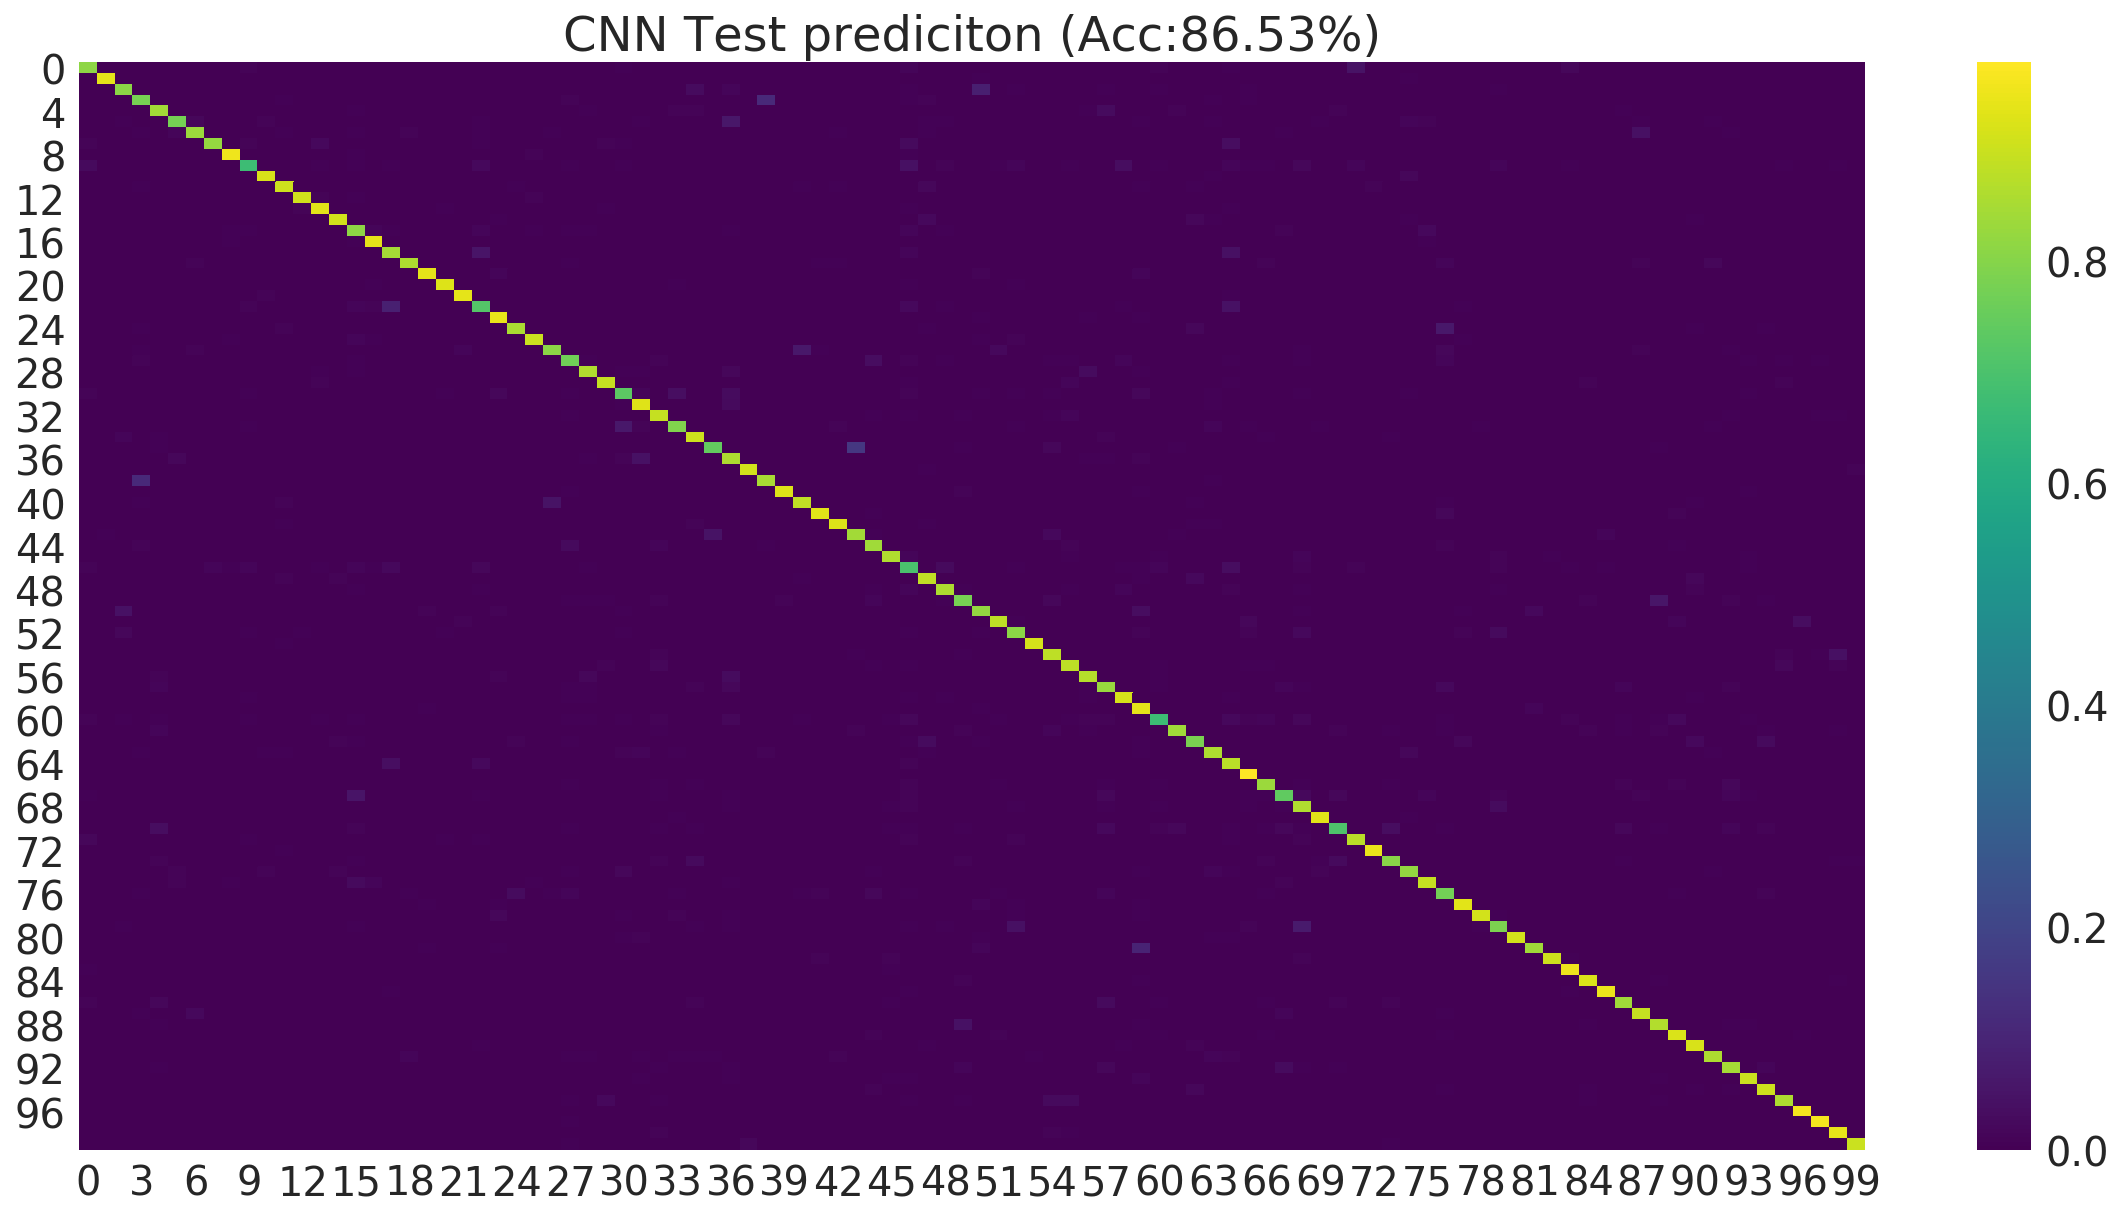

array([32, 29,  2, ..., 50,  5, 72])

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns

cm = confusion_matrix(y_cat_cnn, y_hat_cnn)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc = accuracy_score(y_cat_cnn, y_hat_cnn)
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(20,10))
    
sns.set_style(None, rc={"axes.labelcolor":"White"})
heatmap = sns.heatmap(cm, ax=ax, cbar=1, cmap='viridis')
plt.title('CNN Test prediciton (Acc:{:.2f}%)'.format(acc*100))
#plt.setp(ax.get_xticklabels(), color="White")
#plt.setp(ax.get_yticklabels(), color="White")
#plt.setp(plt.colorbar.colorbase(), color="White")
#l = plt.legend()
#ax.collections[0].colorbar.set_ticts("")
plt.show()
#fig.savefig("cnn.png", transparent=2)

### Create CoreML Model

In [15]:
coreml_model_cnn = coremltools.converters.keras.convert(
    model, 
    input_names='drawing', 
    class_labels='100-categories.txt'
)

coreml_model_cnn.save(model_name+'_array.mlmodel')

0 : reshape_1_input, <keras.engine.topology.InputLayer object at 0x7f8e67727190>
1 : reshape_1, <keras.layers.core.Reshape object at 0x7f8e67727110>
2 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7f8e67727310>
3 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x7f8e0fd55310>
4 : conv2d_1_permute_batch_normalization_1, <keras.layers.core.Permute object at 0x7f8e1727e6d0>
5 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7f8e67727210>
6 : batch_normalization_1_permute_max_pooling2d_1, <keras.layers.core.Permute object at 0x7f8e17551f90>
7 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7f8ee4476a90>
8 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7f8e42943e50>
9 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x7f8e174a5690>
10 : conv2d_2_permute_batch_normalization_2, <keras.layers.core.Permute object at 0x7f8e17551f50>
11 : batch_normalization_2, <keras.layers.normalizat

# Random Forests

In [15]:
from sklearn.ensemble import RandomForestClassifier

trees = 5

rf = RandomForestClassifier(
    n_estimators=trees,
    max_depth=None,
    n_jobs=1,
    verbose=1,
    class_weight=None
)

rf.fit(X_train_rf, y_train_rf)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

### Random Forests Predict -- Validation

In [16]:
y_cat_rf_valid = y_valid_rf
y_hat_rf_valid = rf.predict(X_valid_rf)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


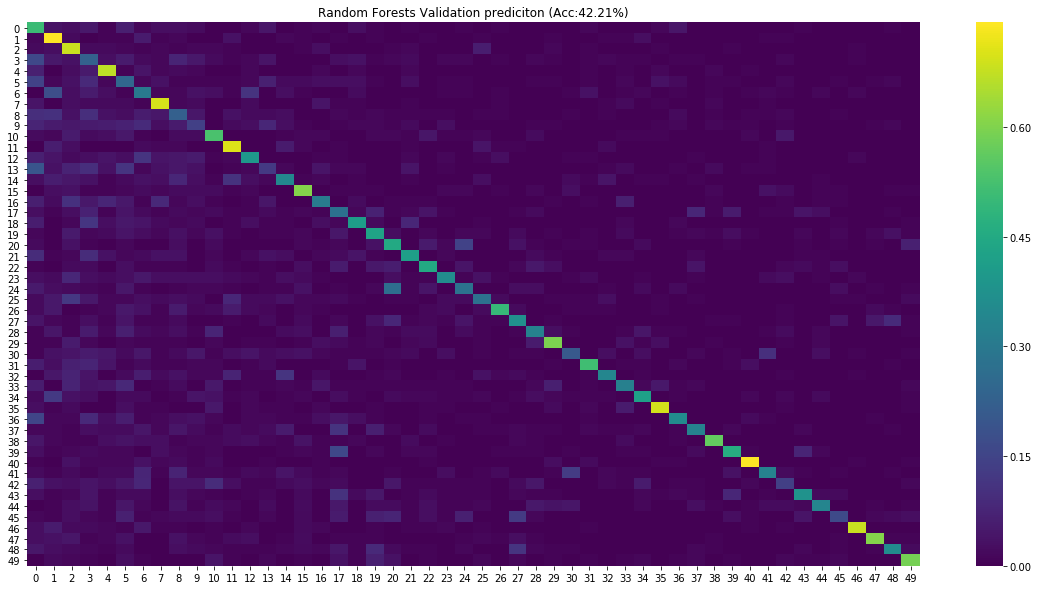

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns

cm = confusion_matrix(y_cat_rf_valid, y_hat_rf_valid)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc = accuracy_score(y_cat_rf_valid, y_hat_rf_valid)

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm, ax=ax, cmap='viridis')
plt.title('Random Forests Validation prediciton (Acc:{:.2f}%)'.format(acc*100))
plt.show()

### Random Forests Predict -- Test

In [18]:
y_cat_rf_test = y_test_rf
y_hat_rf_test = rf.predict(X_test_rf)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


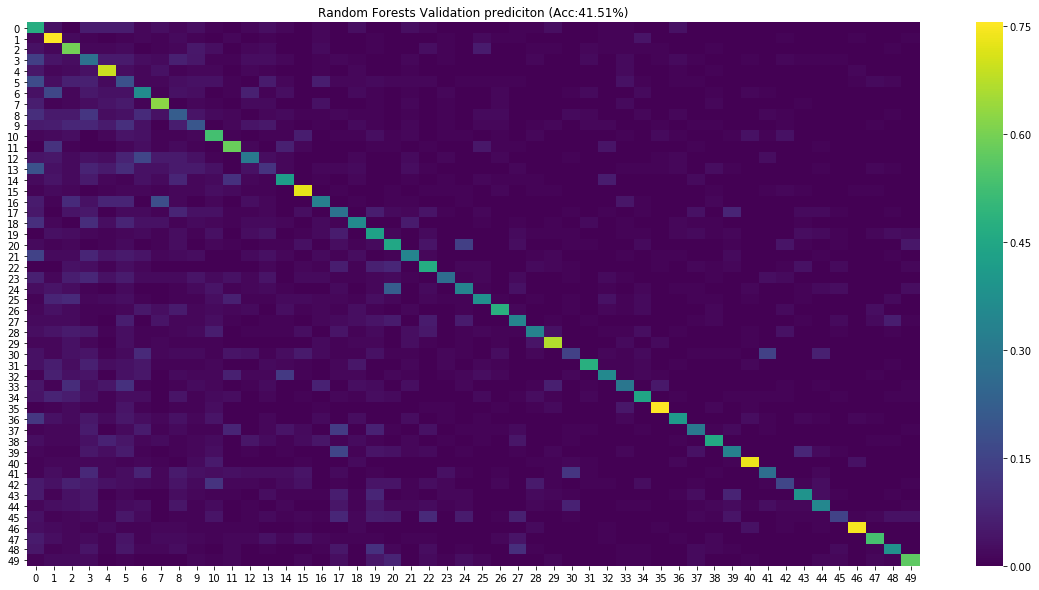

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns

cm = confusion_matrix(y_cat_rf_test, y_hat_rf_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc = accuracy_score(y_cat_rf_test, y_hat_rf_test)

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm, ax=ax, cmap='viridis')
plt.title('Random Forests Validation prediciton (Acc:{:.2f}%)'.format(acc*100))
plt.show()

### Create CoreML Model

In [21]:
with open('50-categories.txt') as f:
    class_names = f.read().splitlines()

print(class_names)

    

['airplane', 'apple', 'banana', 'bee', 'bicycle', 'bird', 'birthday cake', 'bowtie', 'butterfly', 'cat', 'chair', 'clock', 'crown', 'dog', 'donut', 'door', 'eyeglasses', 'flower', 'flying saucer', 'hammer', 'hot air balloon', 'hot dog', 'ice cream', 'laptop', 'light bulb', 'moon', 'mug', 'mushroom', 'paper clip', 'pencil', 'power outlet', 'sailboat', 'smiley face', 'snake', 'snowman', 'stairs', 'star', 'stop sign', 'table', 'tennis racquet', 'The Eiffel Tower', 'The Mona Lisa', 'toilet', 'tornado', 'traffic light', 'tree', 'triangle', 't-shirt', 'umbrella', 'wine glass']


In [25]:
%%time

model_name = 'rf_50cat_'+ str(samples) +'img_'+ str(trees) +'trees'

coreml_model_rf = coremltools.converters.sklearn.convert(
    rf,
    input_features='drawing',
    output_feature_names="catagory"
)

# oreml_model_cnn = coremltools.converters.keras.convert(
#     model, 
#     input_names='drawing', 
#     class_labels='50-categories.txt'
# )

coreml_model_rf.save(model_name+'_array.mlmodel')

CPU times: user 16.4 s, sys: 304 ms, total: 16.7 s
Wall time: 16.5 s
